# CNN

Inspired by:
- https://tf.keras.io/examples/timeseries/timeseries_classification_from_scratch/

## Set-up

In [1]:
import sys, os
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
def singleGraph(df):
    fig = go.Figure()
    for col in df.columns:
      fig.add_trace(go.Scatter(x=df.index,y=df[col],name=col))
    return fig

def tripleGraph(df, fig_title="Test"):
    col_num = 1
    fig = make_subplots(rows=1, cols=3)
    for col in df.columns:
      fig.add_trace(go.Scatter(x=df.index,y=df[col],name=col), row=1, col=col_num)
      col_num += 1
    fig.update_layout(height=1080/2, width=1920/2, title_text=fig_title)
    return fig

def tripleGraph_vertical(df, fig_title="Test"):
    row_num = 1
    fig = make_subplots(rows=3, cols=1)
    for col in df.columns:
      fig.add_trace(go.Scatter(x=df.index,y=df[col],name=col), row=row_num, col=1)
      row_num += 1
    fig.update_layout(height=1920/2, width=1080/2, title_text=fig_title)
    return fig

def comparaisonGraph(df1, df2, fig_title="Test"):    
    col_num = 1
    fig = make_subplots(rows=2, cols=3)
    for col in df1.columns:
        fig.add_trace(go.Scatter(x=df1.index,y=df1[col],name=col), row=1, col=col_num)
        fig.add_trace(go.Scatter(x=df2.index,y=df2[col],name=col), row=2, col=col_num)
        col_num += 1
    fig.update_layout(height=1080/2, width=1920/2, title_text=fig_title)
    return fig

def comparaisonGraph_vertical(df1, df2, fig_title="Test"):    
    row_num = 1
    fig = make_subplots(rows=3, cols=2)
    for col in df1.columns:
        fig.add_trace(go.Scatter(x=df1.index,y=df1[col],name=col), row=row_num, col=1)
        fig.add_trace(go.Scatter(x=df2.index,y=df2[col],name=col), row=row_num, col=2)
        row_num += 1
    fig.update_layout(height=1920/2, width=1080/2, title_text=fig_title)
    return fig

In [3]:
SEPARATOR = ";"

DATE = "2023_04_14"
DATA_FOLDER = os.path.join("../data/android_app/", DATE)

DATA_FILES = [file for file in os.listdir(DATA_FOLDER) if os.path.isfile(os.path.join(DATA_FOLDER, file)) and file.endswith(".txt")]
NB_DATA_FILES = len(DATA_FILES)

MAX_LENGTH = -1

for file in DATA_FILES:
    df = pd.read_csv(os.path.join(DATA_FOLDER, file), sep=SEPARATOR, header=None, names=["ay", "ax", "az"])
    if df.shape[0] > MAX_LENGTH:
        MAX_LENGTH = df.shape[0]

In [4]:
MAX_LENGTH

9489

## Load Data

In [5]:
acc_data = np.empty(shape=[NB_DATA_FILES, 3, MAX_LENGTH])

i = 0
for file in DATA_FILES:
    df = pd.read_csv(os.path.join(DATA_FOLDER, file), sep=SEPARATOR, header=None, names=["ay", "ax", "az"])
    acc = np.array([df["ax"], df["ay"], df["az"]])
    if acc.shape[1] < MAX_LENGTH:
        empty_cols = np.zeros((3, MAX_LENGTH - acc.shape[1]))
        empty_cols[2,:] = 9.81
        acc = np.append(acc, empty_cols, axis=1)
    acc_data[i] = acc
    i += 1

print(type(acc_data))
print(acc_data.shape)
print(acc_data)

<class 'numpy.ndarray'>
(1312, 3, 9489)
[[[ 1.81959330e-01  7.66144540e-02 -1.14921680e-01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 6.03338840e-01 -9.38527050e-01  4.78840350e-01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 9.50976900e+00  1.06111020e+01  1.11665560e+01 ...  9.81000000e+00
    9.81000000e+00  9.81000000e+00]]

 [[ 3.83072270e-02  5.74608400e-02  1.81959330e-01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 7.56567700e-01  8.61912600e-01  6.41646000e-01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.02184520e+01  1.03046450e+01  9.84495700e+00 ...  9.81000000e+00
    9.81000000e+00  9.81000000e+00]]

 [[ 3.83072270e-02  5.74608400e-02  1.81959330e-01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-7.56567700e-01 -8.61912600e-01 -6.41646000e-01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.02184520e+01  1.03046450e+01  9.84495700e+00 ...  9.81000000e+00
    9.81000000e+00  9.8100000

## Load Labels

In [6]:
labels = pd.read_csv(os.path.join(DATA_FOLDER, DATE + ".labels"), sep=",", header=0)
labels = labels.values

acc_data_labels = np.empty(shape=[NB_DATA_FILES, 2], dtype=object)

for i in range(NB_DATA_FILES):
    file = DATA_FILES[i]
    acc_data_labels[i][0] = file
    for j in range(labels.shape[0]):
        if file.startswith(labels[j][0][:-4]):
            acc_data_labels[i][1] = labels[j][1]

# print(type(acc_data_labels))
# print(acc_data_labels.shape)
# print(acc_data_labels)

from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
encoded_labels = label_encoder.fit_transform(acc_data_labels[:,1])
acc_data_labels[:,1] = encoded_labels

print(type(acc_data_labels))
print(acc_data_labels.shape)
print(acc_data_labels)

<class 'numpy.ndarray'>
(1312, 2)
[['DATA1.txt' 4]
 ['DATA10.txt' 4]
 ['DATA10_i.txt' 4]
 ...
 ['DATA9_r_m.txt' 4]
 ['DATA9_r_m_n.txt' 4]
 ['DATA9_r_n.txt' 4]]


In [7]:
NUM_CLASSES = len(np.unique(acc_data_labels[:,1]))
print(np.unique(acc_data_labels[:,1]))

print(NUM_CLASSES)

[0 1 2 3 4 5 6]
7


## Visualize Data

In [8]:
df = pd.DataFrame(acc_data[0].transpose())
df
tripleGraph(df, acc_data_labels[0][0])

In [9]:
data = pd.read_csv(os.path.join(DATA_FOLDER, "DATA40.txt"), sep=SEPARATOR, header=1, names=["ay", "ax", "az"])
tripleGraph(data)

## Create Train/Test Datasets

In [10]:
idx = np.random.permutation(NB_DATA_FILES)
acc_data = acc_data[idx]
acc_data_labels = acc_data_labels[idx]

# print(acc_data)
# print(acc_data_labels)

In [11]:
TRAIN_PERCENTAGE = 70

NB_TRAIN = int((TRAIN_PERCENTAGE * NB_DATA_FILES) / 100)

print(NB_DATA_FILES)
print(NB_TRAIN)

1312
918


In [12]:
x_train, y_train = acc_data[:NB_TRAIN], acc_data_labels[:NB_TRAIN]
x_test, y_test = acc_data[NB_TRAIN:], acc_data_labels[NB_TRAIN:]
print(x_train.shape[1:])

(3, 9489)


In [13]:
# Shuffle training set -> validation_split later
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

## Build Model

In [14]:
def make_model(input_shape, num_classes):
    input_layer = tf.keras.layers.Input(input_shape)

    conv1 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.ReLU()(conv1)

    conv2 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.ReLU()(conv2)

    conv3 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.ReLU()(conv3)

    gap = tf.keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = tf.keras.layers.Dense(num_classes, activation="softmax")(gap)

    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:], num_classes=NUM_CLASSES)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 9489)]         0         
                                                                 
 conv1d (Conv1D)             (None, 3, 64)             1821952   
                                                                 
 batch_normalization (Batch  (None, 3, 64)             256       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 3, 64)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 64)             12352     
                                                                 
 batch_normalization_1 (Bat  (None, 3, 64)             256       
 chNormalization)                                            

## Train Model

In [15]:
EPOCHS = 500
BATCH_SIZE = 32

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    np.asarray(y_train[:,1]).astype("short"),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)


Epoch 1/500
23/23 [==============================] - 6s 115ms/step - loss: 1.9024 - sparse_categorical_accuracy: 0.1471 - val_loss: 2.5048 - val_sparse_categorical_accuracy: 0.1304 - lr: 0.0010
Epoch 2/500


C:\Users\julie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



23/23 [==============================] - 2s 92ms/step - loss: 1.6165 - sparse_categorical_accuracy: 0.3488 - val_loss: 2.2733 - val_sparse_categorical_accuracy: 0.1304 - lr: 0.0010
Epoch 3/500
23/23 [==============================] - 2s 97ms/step - loss: 1.3841 - sparse_categorical_accuracy: 0.5613 - val_loss: 2.3998 - val_sparse_categorical_accuracy: 0.1304 - lr: 0.0010
Epoch 4/500
23/23 [==============================] - 2s 96ms/step - loss: 1.1915 - sparse_categorical_accuracy: 0.6512 - val_loss: 2.6899 - val_sparse_categorical_accuracy: 0.1304 - lr: 0.0010
Epoch 5/500
23/23 [==============================] - 2s 89ms/step - loss: 0.9153 - sparse_categorical_accuracy: 0.7180 - val_loss: 2.5552 - val_sparse_categorical_accuracy: 0.1793 - lr: 0.0010
Epoch 6/500
23/23 [==============================] - 2s 91ms/step - loss: 0.5409 - sparse_categorical_accuracy: 0.8583 - val_loss: 2.4674 - val_sparse_categorical_accuracy: 0.1793 - lr: 0.0010
Epoch 7/500
23/23 [============================

## Evaluate Model

In [16]:

model = tf.keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, np.asarray(y_test[:,1]).astype("short"))

print("Test accuracy", test_acc)
print("Test loss", test_loss)


13/13 [==============================] - 1s 12ms/step - loss: 0.1644 - sparse_categorical_accuracy: 0.9365
Test accuracy 0.9365482330322266
Test loss 0.16441087424755096


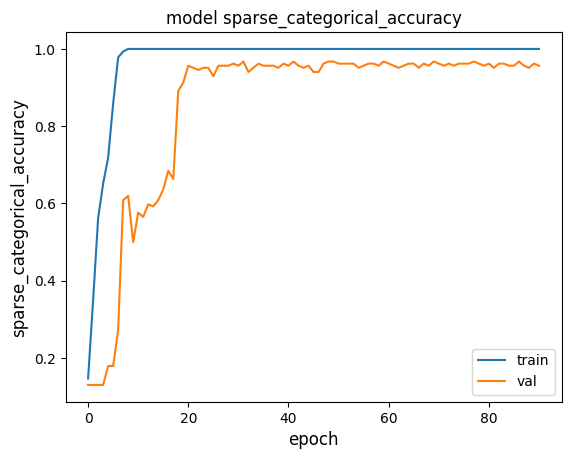

In [17]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()


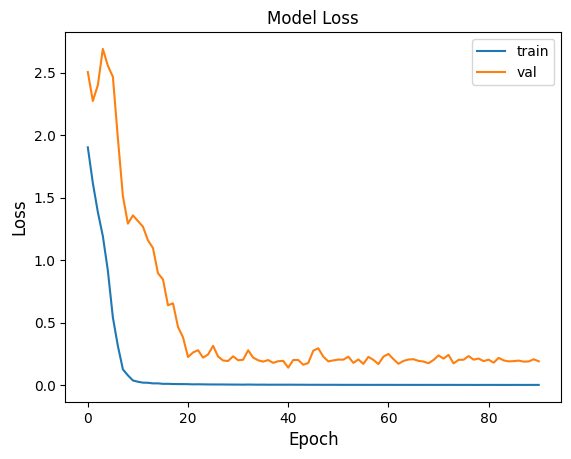

In [18]:

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss', fontsize='large')
plt.xlabel('Epoch', fontsize='large')
plt.legend(['train', 'val'], loc='best')
plt.show()
plt.close()



In [41]:

random_index = np.random.randint(0, len(acc_data))
random_data = acc_data[random_index]


predicted_class_probabilities = model.predict(np.expand_dims(random_data, axis=0))[0]
predicted_class_index = np.argmax(predicted_class_probabilities)

true_class = acc_data_labels[random_index]


print("Nom de la donnée choisie:", f"acc_data_{random_index}")
print("Classe prédite:", predicted_class_index)
print("Classe réelle:", true_class)

1/1 [==============================] - 0s 47ms/step
Nom de la donnée choisie: acc_data_259
Classe prédite: 3
Classe réelle: ['DATA34_i_m_n.txt' 6]


## Create longer sequences

In [211]:
import os
import random

def concat_random_files(input_folder, output_file, num_files=5):
    txt_files = [f for f in os.listdir(input_folder) if f.endswith(".txt")]

    selected_files = random.sample(txt_files, num_files)
    print(selected_files)

    with open(output_file, 'w') as output:
        for file_name in selected_files:
            file_path = os.path.join(input_folder, file_name)
            with open(file_path, 'r') as input_file:
                content = input_file.read()
                output.write(content)

input_folder = "../data/android_app/2023_04_14"
output_file = "fichier_concatene.txt"
concat_random_files(input_folder, output_file)


['DATA17_r_m.txt', 'DATA22_ri.txt', 'DATA63_r_n.txt', 'DATA55_ri_n.txt', 'DATA61.txt']


In [212]:
data = pd.read_csv("fichier_concatene.txt", sep=SEPARATOR, header=1, names=["ay", "ax", "az"])
tripleGraph(data)

In [213]:
df = pd.read_csv("fichier_concatene.txt", sep=SEPARATOR, header=None, names=["ay", "ax", "az"])

acc = np.array([df["ax"], df["ay"], df["az"]])
if acc.shape[1] < MAX_LENGTH:
        empty_cols = np.zeros((3, MAX_LENGTH - acc.shape[1]))
        empty_cols[2,:] = 9.81
        acc = np.append(acc, empty_cols, axis=1)

In [214]:
df.shape[1]

3

In [215]:
print(acc.shape)


(3, 10869)


In [254]:
random_data = acc[:,7500:9000]
df_1 = pd.DataFrame(random_data.transpose())
df_1
tripleGraph(df_1)

In [255]:

random_data = acc[:, 7500:9000]

print(random_data.shape)
if random_data.shape[1] < MAX_LENGTH:
        empty_cols = np.zeros((3, MAX_LENGTH - random_data.shape[1]))
        empty_cols[2,:] = 9.81
        random_data = np.append(random_data, empty_cols, axis=1)
print(random_data.shape)
predicted_class_probabilities = model.predict(np.expand_dims(random_data, axis=0))[0]
predicted_class_index = np.argmax(predicted_class_probabilities)



print("Classe prédite:", predicted_class_index)


(3, 1800)
(3, 9489)
1/1 [==============================] - 0s 36ms/step
Classe prédite: 4


In [224]:
window_size = 1400
step_size = 1400
predictions = []
print(acc.shape[1])
for i in range(0, acc.shape[1] - window_size, step_size):
    print("i ",i)
    window_data = acc[:, i:i + window_size]
    if window_data.shape[1] < MAX_LENGTH:
        empty_cols = np.zeros((3, MAX_LENGTH - window_data.shape[1]))
        empty_cols[2,:] = 9.81
        window_data = np.append(window_data, empty_cols, axis=1)

    
    prediction = model.predict(np.expand_dims(window_data, axis=0))[0]
    prediction = np.argmax(prediction)
    print(prediction)

    predictions.append(prediction)
print(predictions)

10869
i  0
1/1 [==============================] - 0s 29ms/step


1
i  1400
1/1 [==============================] - 0s 28ms/step
1
i  2800
1/1 [==============================] - 0s 34ms/step
6
i  4200
1/1 [==============================] - 0s 30ms/step
4
i  5600
1/1 [==============================] - 0s 29ms/step
1
i  7000
1/1 [==============================] - 0s 21ms/step
1
i  8400
1/1 [==============================] - 0s 25ms/step
1
[1, 1, 6, 4, 1, 1, 1]


## Fenêtre glissante

In [251]:

window_size = 1500 
step_size = 1500

predictions = []


for i in range(0, acc.shape[1] - window_size, step_size):
    print("i ",i)
    window_data = acc[:, i:i + window_size]
    if window_data.shape[1] < MAX_LENGTH:
        empty_cols = np.zeros((3, MAX_LENGTH - window_data.shape[1]))
        empty_cols[2,:] = 9.81
        window_data = np.append(window_data, empty_cols, axis=1)

    
    prediction = model.predict(np.expand_dims(window_data, axis=0))[0]
    #if max(prediction)>0.94:
        #prediction = np.argmax(prediction)
    #else:
        #prediction = -1
    print(prediction)

    predictions.append(prediction)
print(predictions)





i  0
1/1 [==============================] - 0s 30ms/step


[1.6955272e-04 9.9769348e-01 4.9311493e-04 2.3205408e-04 2.5078660e-04
 1.5233651e-04 1.0086292e-03]
i  1500
1/1 [==============================] - 0s 20ms/step
[1.49044371e-03 3.43192951e-03 9.92698133e-01 1.36451412e-03
 4.61912568e-04 4.33017645e-04 1.20072145e-04]
i  3000
1/1 [==============================] - 0s 16ms/step
[0.01495391 0.4845875  0.44946966 0.023176   0.00578361 0.00803811
 0.01399114]
i  4500
1/1 [==============================] - 0s 18ms/step
[3.8788145e-04 9.4755673e-01 5.2739447e-04 6.3964527e-04 3.3946224e-03
 8.2868192e-04 4.6665031e-02]
i  6000
1/1 [==============================] - 0s 32ms/step
[5.6192733e-04 9.8055309e-01 6.1347836e-04 7.2611915e-04 4.6032625e-03
 6.2249653e-04 1.2319575e-02]
i  7500
1/1 [==============================] - 0s 21ms/step
[1.0370883e-03 2.1704838e-03 1.1853242e-03 7.8300893e-04 9.9040246e-01
 1.5994508e-03 2.8222685e-03]
i  9000
1/1 [==============================] - 0s 15ms/step
[0.00205918 0.01130187 0.00144944 0.00176037 0.9

[750.0, 2250.0, 3750.0, 5250.0, 6750.0, 8250.0, 9750.0]
[1, 2, -1, 1, 1, 4, 4]


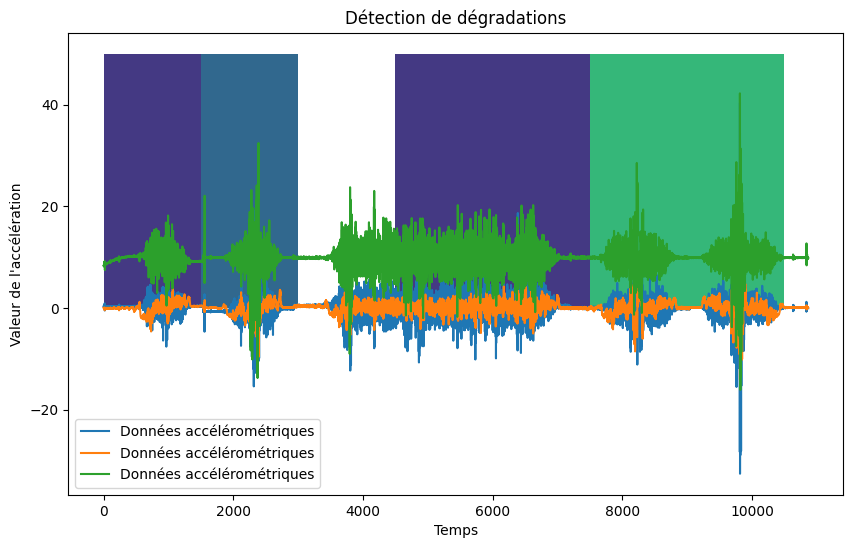

In [248]:
def plot_results(data,values):
    plt.figure(figsize=(10, 6))
    

    square_width = 1500

    colors = []
    for value in values:
        if value == -1:
            colors.append('white')
        else:
            colors.append(plt.cm.viridis(value / 6))  
    positions = []
    for i in range(0,10869,1500):
        positions.append(i+(1500/2))
    positions.pop(-1)
    print(positions)
    print(values)
    
    plt.bar(positions, 50, color=colors, width=square_width)
    plt.plot(data, label='Données accélérométriques')
    plt.legend()
    plt.xlabel('Temps')
    plt.ylabel("Valeur de l'accélération")
    plt.title('Détection de dégradations')
    plt.show()
plot_results(data,predictions)